# Importing necessary libraries and downloading files



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
! wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
! wget https://raw.githubusercontent.com/oarriaga/face_classification/master/trained_models/emotion_models/fer2013_mini_XCEPTION.110-0.65.hdf5
! wget -O surprise.jpg https://images.unsplash.com/photo-1485546246426-74dc88dec4d9?ixlib=rb-1.2.1

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nicolejyt/facialexpressionrecognition
! unzip facialexpressionrecognition.zip 



# Importing dataset



In [0]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'  #to suppress SettingWithCopyWarning

#Reading the dataset
dataset = pd.read_csv("fer2013.csv")

#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

#Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

# Preparing X_train, y_train, X_test, y_test

In [4]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

'''
np.vstack stack element in sequence vertically (eg: [2, 3, 4] --> array([[2],
                                                                         [3],
                                                                         [4]])
                                               )
'''
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)


#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")


shape of X_train and y_train is (28709, 48, 48, 1) and (28709, 1) respectively.
shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [0]:
# Change to float datatype
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

# Getting number of classes and  input_shape

In [6]:
# Find the unique numbers from the train labels

classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


# Defining emotions name

In [0]:
#Defining labels 

def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

# Plotting an image each from train and test set

Text(0.5, 1.0, 'Ground Truth : Surprise')

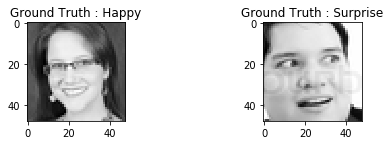

In [8]:
# resize plots
plt.figure(figsize=[6,4])

# Display random image from training data
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_train[7]), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[7]))))

# Display random image from testing data
plt.subplot(1,3,3)
plt.imshow(np.squeeze(X_test[1500]), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500]))))

# Defining model architecture

In [0]:
def createModel():
    
    #Model Initialization
    model = Sequential() 
    
    #Adding Input Layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    
    #Adding more layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
  
    #Flattening
    model.add(Flatten())
    
    #Adding fully connected layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    
    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

# Creating and training 1st model

In [10]:
#Creating 1st model

model1 = createModel()
batch_size = 256
epochs = 100
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxP

In [11]:
#Training our 1st model

history = model1.fit(train_data, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(test_data, test_labels_one_hot))

Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 8s 272us/step - loss: 1.8059 - acc: 0.2547 - val_loss: 1.7071 - val_acc: 0.3252
Epoch 2/100
28709/28709 [==============================] - 4s 148us/step - loss: 1.6095 - acc: 0.3713 - val_loss: 1.6421 - val_acc: 0.4096
Epoch 3/100
28709/28709 [==============================] - 4s 148us/step - loss: 1.4957 - acc: 0.4245 - val_loss: 1.4516 - val_acc: 0.4505
Epoch 4/100
28709/28709 [==============================] - 4s 147us/step - loss: 1.4042 - acc: 0.4633 - val_loss: 1.4333 - val_acc: 0.4452
Epoch 5/100
28709/28709 [==============================] - 4s 148us/step - loss: 1.3344 - acc: 0.4881 - val_loss: 1.3703 - val_acc: 0.4784
Epoch 6/100
28709/28709 [==============================] - 4s 149us/step - loss: 1.2765 - acc: 0.5158 - val_loss: 1.3502 - val_acc: 0.4951
Epoch 7/100
28709/28709 [==============================] - 4s 149us/s

# Evaluating 1st model and plotting curves

In [12]:
#Evaluating model performance

model1.evaluate(test_data, test_labels_one_hot)

3589/3589 [==============================] - 0s 84us/step


[1.560699536827621, 0.6182780718946231]

Text(0.5, 1.0, 'Accuracy Curves')

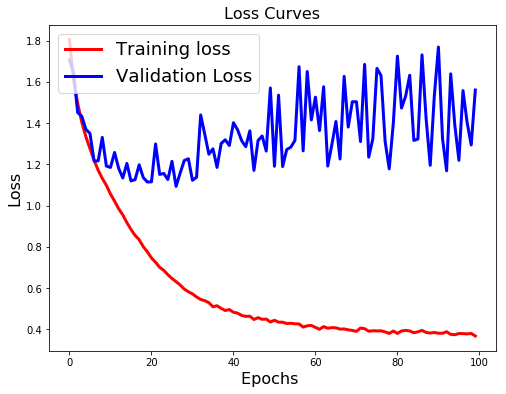

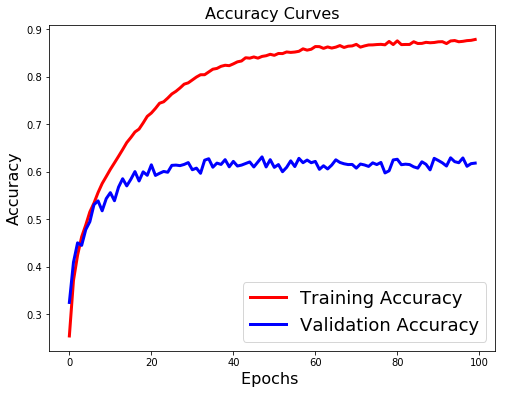

In [13]:
#Plotting accuracy and loss curves for 1st model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

>***As you can see that our model performs well on training set but fails to do so on test set, there must be overfitting. To remove overfitting, we can do data augmentation.***




# Data augmentation 

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

# Creating and training 2nd model

In [15]:
#Creating 2nd model and training(fitting)

model2 = createModel()
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 256
epochs = 100

# Fit the model on the batches generated by datagen.flow().
history2 = model2.fit_generator(datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(test_data, test_labels_one_hot),
                              )

Epoch 1/100
113/113 [==============================] - 10s 87ms/step - loss: 1.8276 - acc: 0.2455 - val_loss: 1.8093 - val_acc: 0.2708
Epoch 2/100
113/113 [==============================] - 9s 80ms/step - loss: 1.7515 - acc: 0.2834 - val_loss: 1.7041 - val_acc: 0.3583
Epoch 3/100
113/113 [==============================] - 9s 80ms/step - loss: 1.6789 - acc: 0.3256 - val_loss: 1.5595 - val_acc: 0.4113
Epoch 4/100
113/113 [==============================] - 9s 79ms/step - loss: 1.6113 - acc: 0.3652 - val_loss: 1.5092 - val_acc: 0.4166
Epoch 5/100
113/113 [==============================] - 9s 79ms/step - loss: 1.5454 - acc: 0.3986 - val_loss: 1.4147 - val_acc: 0.4553
Epoch 6/100
113/113 [==============================] - 9s 81ms/step - loss: 1.4936 - acc: 0.4212 - val_loss: 1.4186 - val_acc: 0.4413
Epoch 7/100
113/113 [==============================] - 9s 80ms/step - loss: 1.4372 - acc: 0.4460 - val_loss: 1.3468 - val_acc: 0.4974
Epoch 8/100
113/113 [==============================] - 9s 81m

# Evaluating 2nd model and plotting curves

In [16]:
#Evaluating model performance

model2.evaluate(test_data, test_labels_one_hot)

3589/3589 [==============================] - 0s 79us/step


[1.0567782257685392, 0.6043466146641968]

Text(0.5, 1.0, 'Accuracy Curves')

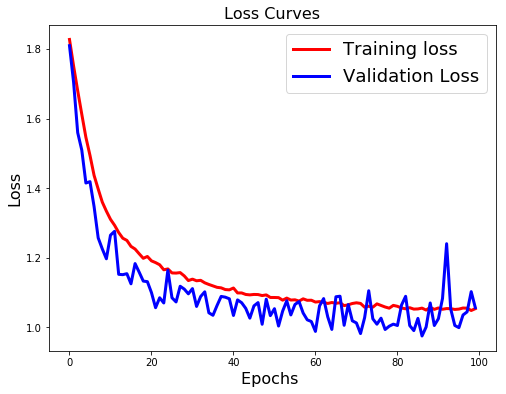

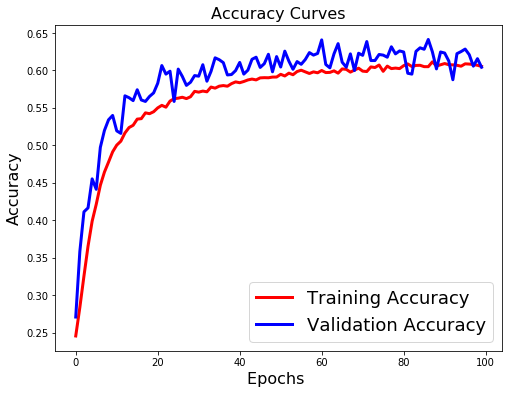

In [17]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['acc'],'r',linewidth=3.0)
plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#Saving our model

In [0]:
#Saving our model
model2.save('my_model.h5')

#Cropping image to get face

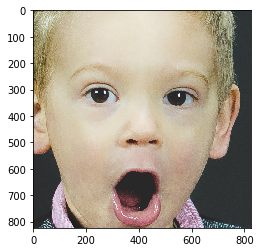

In [110]:
#Cropping image

from PIL import Image
import cv2
import matplotlib.pyplot as plt

faces = []

img = Image.open("surprise.jpg")
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(np.asarray(img), 1.3, 5)
for (x, y, w, h) in faces:
  if len(faces) == 1: #Use simple check if one face is detected, or multiple (measurement error unless multiple persons on image)
    crop_img = img.crop((x,y,x+w,y+h))
  else:
    print("multiple faces detected, passing over image")

plt.imshow(crop_img)

#Resizing(acc. to model) and predicting results

In [111]:
#Resizing image to required size and processing
test_image = crop_img.resize((48,48),Image.ANTIALIAS)
test_image = np.array(test_image)
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

#scale pixels values to lie between 0 and 1 because we did same to our train and test set
gray = gray/255

#reshaping image (-1 is used to automatically fit an integer at it's place to match dimension of original image)
gray = gray.reshape(-1, 48, 48, 1)

res = model2.predict(gray)

#argmax returns index of max value
result_num = np.argmax(res)

print("Probabilities are " + str(res[0])+"\n")
print("Emotion is "+get_label(result_num))

Probabilities are [8.6966500e-02 3.1855168e-05 5.3059530e-02 1.3219425e-02 1.3421694e-02
 8.0609381e-01 2.7207172e-02]

Emotion is Surprise


**Here the probabilities are as follows :**

* 8.6966500e-02 - Angry
* 3.1855168e-05 - Disgust
* 5.3059530e-02 - Fear
* 1.3219425e-02 - Happy
* 1.3421694e-02 - Sad
* 8.0609381e-01 - Surprise
* 2.7207172e-02 - Neutral

Since probability of being surprise is highest (0.81), emotion is **surprise** .

#Loading pre-trained model

*Here I'm using fer2013_mini_XCEPTION.110-0.65 model.*



In [0]:
from keras.models import load_model
pretrained_model = load_model("fer2013_mini_XCEPTION.110-0.65.hdf5")

#Prediction using pre-trained model

In [112]:
#Resizing image to required size
test_image = crop_img.resize((64,64),Image.ANTIALIAS)

#Converting image to array
test_image = np.array(test_image)

#converting to grayscale
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

#scale pixels values to lie between 0 and 1 because we did same to our train and test set
gray = gray/255

#reshaping image (-1 is used to automatically fit an integer at it's place to match dimension of original image)
gray = gray.reshape(-1, 64, 64, 1)

res = pretrained_model.predict(gray)

#argmax returns index of max value
result_num = np.argmax(res[0])

# print predictions
print("\nProbabilities are " + str(res[0])+"\n")
print("Emotion is "+ get_label(result_num))


Probabilities are [2.3769777e-02 6.4130991e-06 2.7361888e-02 2.9007331e-02 7.8126509e-03
 7.5060266e-01 1.6143923e-01]

Emotion is Surprise


**Here the probabilities are as follows :**

* 2.3769777e-02  - Angry
* 6.4130991e-06 - Disgust
* 2.7361888e-02 - Fear
* 2.9007331e-02 - Happy
* 7.8126509e-03 - Sad
* 7.5060266e-01 - Surprise
* 1.6143923e-01 - Neutral

Since probability of being surprise is highest (0.75), emotion is **surprise** .

***Our model is predicting better than pre-trained model on this image !***
